<a href="https://colab.research.google.com/github/Jav-Akse/VKR_2022/blob/main/NeuralNetwork_using_StohasticGradientDescent_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подгружаем необходимые библиотеки

In [1]:
import random
import numpy as np

Количество входных, промежуточных и выходных нейронов.
Реализовал на примере классификации цветков ириса. По 4 входным параметрам (INPUT_DIM, длина, ширина лепестка; длина, ширина чашелистика) определяется вид цветка (OUTPUT_DIM, setosa, virginica, versicolor).

In [31]:
INPUT_DIM = 4
OUTPUT_DIM = 3
H_DIM = 10

Простая функция активации. Берет максимум из значения, которое мы передаем и 0

In [3]:
def relu(t):
  return np.maximum(t, 0)

Функция активации в выходном слое моделей нейронной сети

In [4]:
def softmax(t):
  out = np.exp(t)
  return out/np.sum(out)

Та же функция получения ответа, но с модификацией для градиента (по группе образцов)

In [5]:
def softmax_batch(t):
  out = np.exp(t)
  return out/np.sum(out, axis=1, keepdims=True)

Функция кросс энтрапии для подсчета разницы между правильным ответом и полученным

In [6]:
def sparse_cross_entrapy(z, y):
  return -np.log(z[0, y])

Та же функция кросс энтрапии, но с модификацией для группы образцов

In [7]:
def sparse_cross_entrapy_batch(z, y):
  return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

In [8]:
def to_full(y, num_classes):
  y_full = np.zeros((1, num_classes))
  y_full[0, y] = 1
  return y_full

In [9]:
def to_full_batch(y, num_classes):
  y_full = np.zeros((len(y), num_classes))
  for j, yj in enumerate(y):
    y_full[j, yj] = 1
  return y_full

Простая функция активации при обратном прохождении по нейронной сети

In [10]:
def relu_deriv(t):
  return (t >= 0).astype(float)

Загружаем готовый набор данных об ирисах Фишера

In [11]:
from sklearn import datasets
iris = datasets.load_iris()

In [48]:
dataset = [(iris.data[i][None, ...], iris.target[i]) for i in range (len(iris.target))]

Разбиваем датасет для обучаемый и тестовый набор данных

In [24]:
train_data = dataset[:130]
test_data = dataset[130:]

Задаем матрицу весов и вектор смещения для двух слоев нейронной сети

In [32]:
W1 = np.random.randn(INPUT_DIM, H_DIM)
b1 = np.random.randn(1, H_DIM)
W2 = np.random.randn(H_DIM, OUTPUT_DIM)
b2 = np.random.randn(1, OUTPUT_DIM)

Определяем гиперпараметры нейронной сети.
Скорость обучения 0.0001.
Количество эпох (прогонов обучения) 100.
Размер группы ошибок (для вычисления стохастического градиента) 50

In [25]:
LEARNING_RATE = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 50

Прямое и обратное распространение ошибок, обновление параметров нейронной сети и подсчет функции потерь

In [33]:
loss_arr = []
for ep in range(NUM_EPOCHS):
  random.shuffle(train_data)
  for i in range(len(train_data) // BATCH_SIZE):

    batch_x, batch_y = zip(*train_data[i * BATCH_SIZE : i * BATCH_SIZE + BATCH_SIZE])
    x = np.concatenate(batch_x, axis=0)
    y = np.array(batch_y)

    #Forward
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax_batch(t2)
    E = np.sum(sparse_cross_entrapy_batch(z, y))

    #Backward
    y_full = to_full_batch(y, OUTPUT_DIM)
    dE_dt2 = z - y_full
    dE_dW2 = h1.T @ dE_dt2
    dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
    dE_dh1 = dE_dt2 @ W2.T
    dE_dt1 = dE_dh1 * relu_deriv(t1)
    dE_dW1 = x.T @ dE_dt1
    dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

    #Update
    #один шаг градиентного спуска
    W1 = W1 - LEARNING_RATE * dE_dW1
    b1 = b1 - LEARNING_RATE * dE_db1
    W2 = W2 - LEARNING_RATE * dE_dW2
    b2 = b2 - LEARNING_RATE * dE_db2

    loss_arr.append(E)

Функция предсказания ответа

In [27]:
def predict(x):
  t1 = x @ W1 + b1
  h1 = relu(t1)
  t2 = h1 @ W2 + b2
  z = softmax(t2)
  return z

Функция подсчета точности работы нейронной сети в процессе обучения

In [36]:
def calc_accuracy():
  correct = 0
  for x, y in train_data:
    z = predict(x)
    y_pred = np.argmax(z)
    if y_pred == y:
      correct += 1
  acc = correct/len(train_data)
  return acc

Точность

In [37]:
accuracy = calc_accuracy()
print("Accuracy:", accuracy)

Accuracy: 0.9615384615384616


График функции потерь в процессе обучения. Можно заметить, что с увеличением количества повторений алгоритма количество ошибок уменьшается

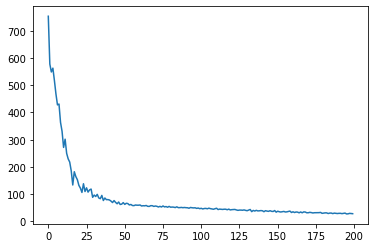

In [35]:
import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()

Подсчет точности на тестовой выборке

In [46]:
def testing_accuracy():
  correct = 0
  for x, y in test_data:
    z = predict(x)
    y_pred = np.argmax(z)
    if y_pred == y:
      correct += 1
  acc = correct/len(test_data)
  return acc

In [47]:
test_accuracy = testing_accuracy()
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9
